In [175]:
import sys 
sys.path.append('lib')
import lib 
import importlib
importlib.reload(lib)

import pandas as pd 
import numpy as np 
import yfinance as yf 
import plotnine as p9
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import norm


# Uma Breve Análise dos Retornos Gerais do Mercado Brasileiro 


In [176]:
symbols = pd.read_csv("symbols.csv") 

symbols.head(3)

,setor,tickers,qtde_teorica
0,bens_indls,WEGE3.SA,1.481593e+09
1,bens_indls,EMBR3.SA,7.346327e+08
2,bens_indls,AZUL4.SA,3.275937e+08


In [177]:
# Lista de tickers de ações
tickers = symbols['tickers'].values.tolist()
tickers.remove('ALSO3.SA')

for t in ['RRRP3.SA', 'ARZZ3.SA', 'SOMA3.SA', 'CIEL3.SA']:
    if t in tickers:
        tickers.remove(t)


In [178]:


returns = lib.create_cumulative_returns(tickers=tickers, start='2024-05-25', end='2025-05-25')
print(returns)


[*********************100%***********************]  81 of 81 completed


WEGE3.SA     0.157511
EMBR3.SA     0.766499
AZUL4.SA    -0.897233
CCRO3.SA     0.115198
GOLL4.SA    -0.044118
               ...   
ENGI11.SA    0.082709
ENEV3.SA     0.109632
EGIE3.SA    -0.028524
EQTL3.SA     0.219697
TAEE11.SA    0.094931
Name: 2025-05-23 00:00:00, Length: 81, dtype: float64


In [179]:
# Cria o DF
returns = pd.DataFrame(returns).reset_index()

# Renomeia as colunas
returns.columns = ['Ações', 'Retornos']

# Captura as 5 maiores altas
top_5_returns = (returns
    .sort_values(by='Retornos', ascending=False)
    .head(n=5))

# Captura as 5 maiores baixas
low_5_returns =  (returns
    .sort_values(by='Retornos', ascending=False)
    .tail(n=5))

In [180]:
# Junta os dataframes com baixa e alta
top_returns = (
              pd.concat([top_5_returns, low_5_returns])
              .sort_values(by='Retornos', ascending=False)
              .assign(Ações=lambda x: pd.Categorical(x['Ações']))
          )

In [181]:
top_returns

,Ações,Retornos
8,MRFG3.SA,1.494524
1,EMBR3.SA,0.766499
7,JBSS3.SA,0.636207
70,SBSP3.SA,0.611661
27,COGN3.SA,0.535335
54,CSAN3.SA,-0.409932
49,BRKM5.SA,-0.420888
62,RADL3.SA,-0.424767
29,VAMO3.SA,-0.470568
2,AZUL4.SA,-0.897233


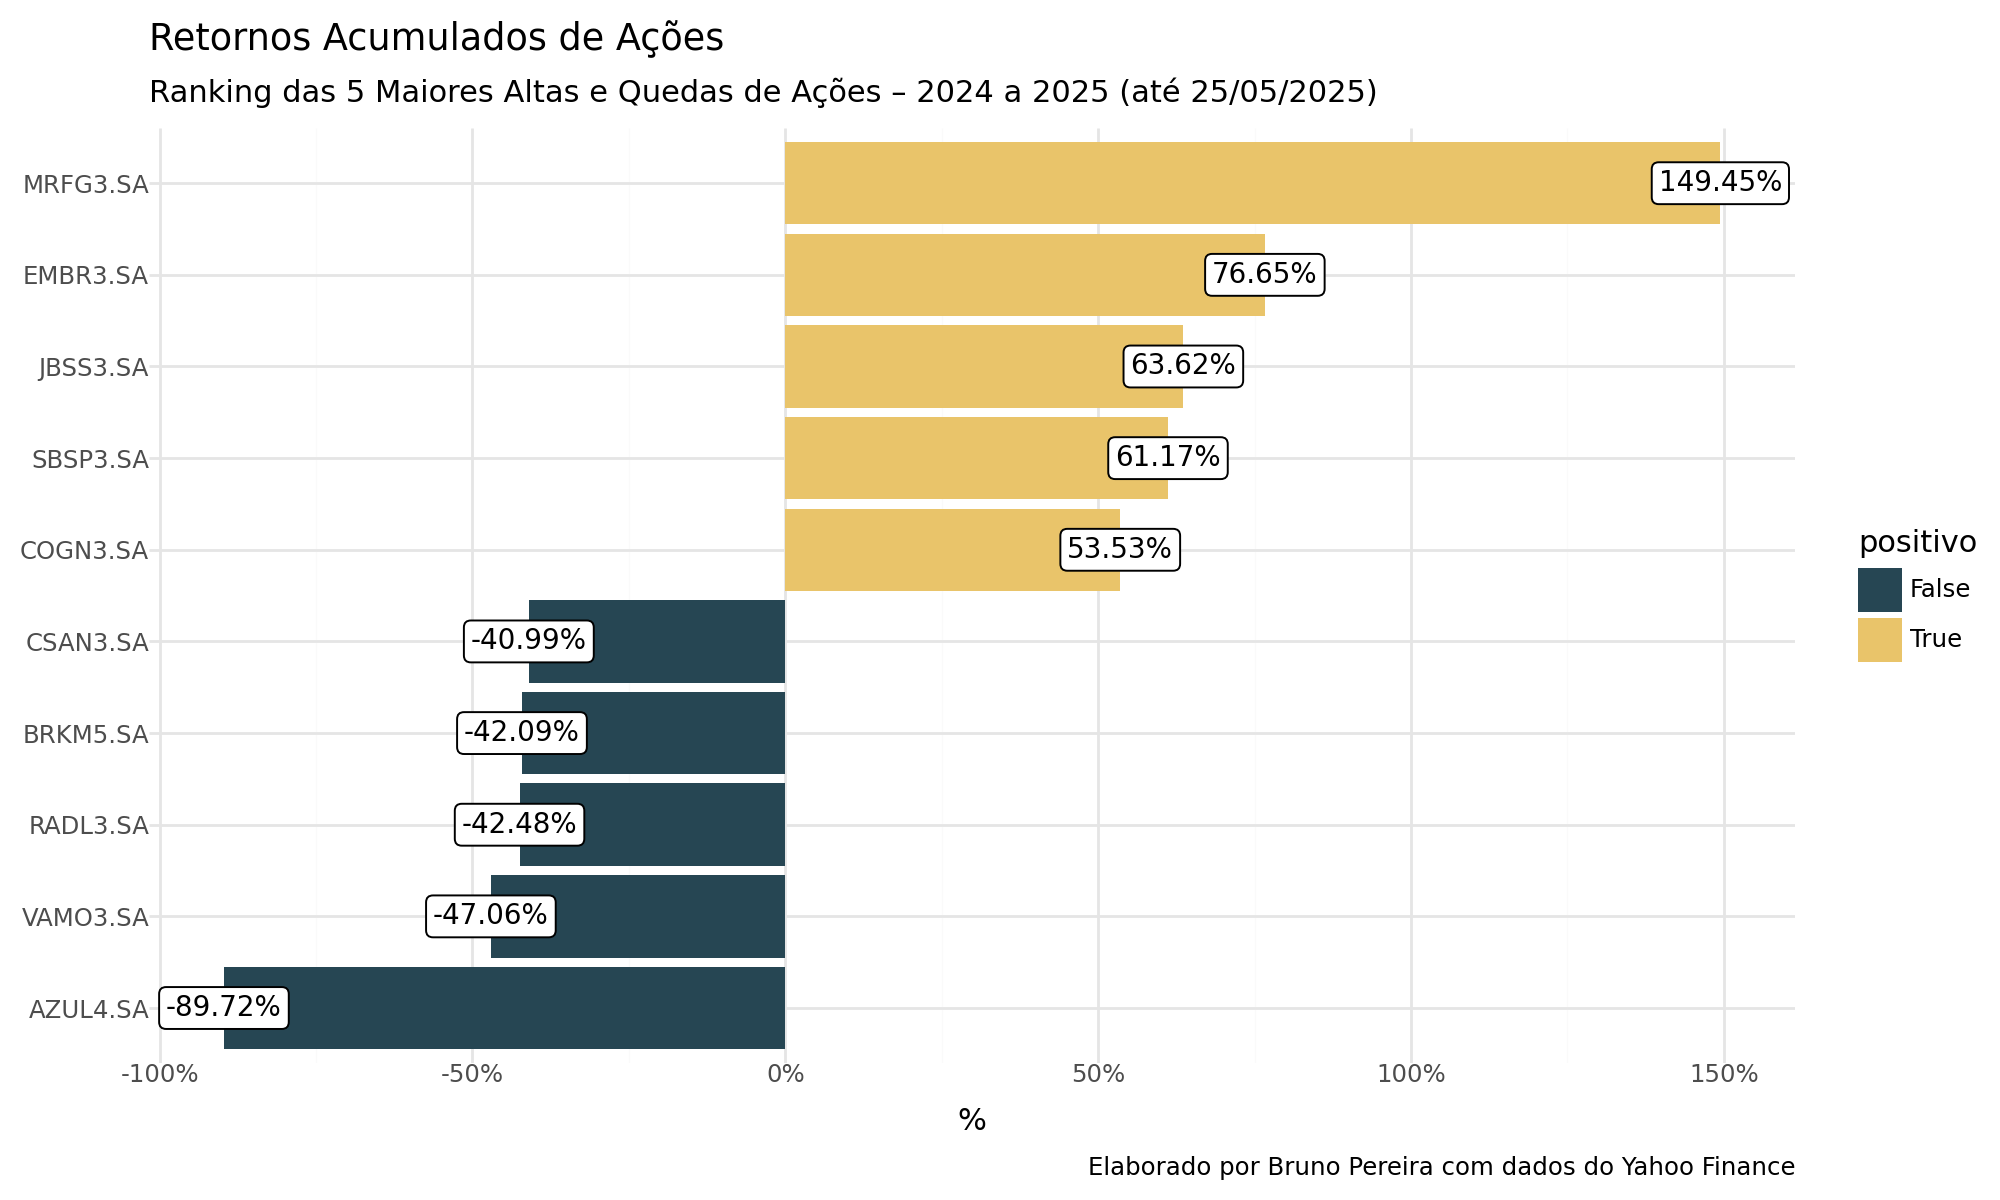

In [182]:
grafico = lib.plot_retornos_acumulados(
    top_returns,
    
    legenda=True
)

grafico



# Risco e Performace 

Um exercício comum em análise de investimentos é comparar o desempenho de uma ação com o desempenho geral do mercado, representado por um índice. Para isso, observa-se primeiro o retorno do mercado num determinado dia e depois calcula-se se a ação teve um desempenho melhor ou pior em relação a esse índice. Os índices funcionam como um resumo do comportamento da maior parte das ações de um determinado mercado ou setor, permitindo assim descrever de forma prática tanto o desempenho quanto a variação dos retornos das ações. Os modelos fatoriais formalizam essa ideia intuitiva, tornando possível analisar com rigor essa relação entre as ações e o mercado, além de expandir o conceito para diversas aplicações.

In [183]:
# Vamos análisar apenas um ativo, escolher o de maior retorno 

ticker1 = 'MRFG3.SA' # A
ticker2 = 'AZUL4.SA' # B
indice = '^BVSP' # IBOV
start = '2024-05-25'
end= '2025-05-25'
stock_A = yf.download(ticker1,start, end)['Close']
stock_B=  yf.download(ticker2,start, end)['Close']
stock_indice = yf.download(indice,start, end)['Close'] 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [184]:
stocks  = stock_A.join(stock_indice)

In [185]:
stocks.head()

Ticker,MRFG3.SA,^BVSP
Date,,
2024-05-27,9.957811,124496.0
2024-05-28,9.966381,123780.0
2024-05-29,9.829268,122707.0
2024-05-31,9.666447,122098.0
2024-06-03,9.829268,122032.0


In [186]:
stocks['MRFG3_returns'] = stocks['MRFG3.SA'].pct_change()
stocks['IBOV_returns'] = stocks['^BVSP'].pct_change()

stocks.dropna(inplace= True)

stocks.head()

Ticker,MRFG3.SA,^BVSP,MRFG3_returns,IBOV_returns
Date,,,,
2024-05-28,9.966381,123780.0,0.000861,-0.005751
2024-05-29,9.829268,122707.0,-0.013758,-0.008669
2024-05-31,9.666447,122098.0,-0.016565,-0.004963
2024-06-03,9.829268,122032.0,0.016844,-0.000541
2024-06-04,9.529334,121802.0,-0.030514,-0.001885


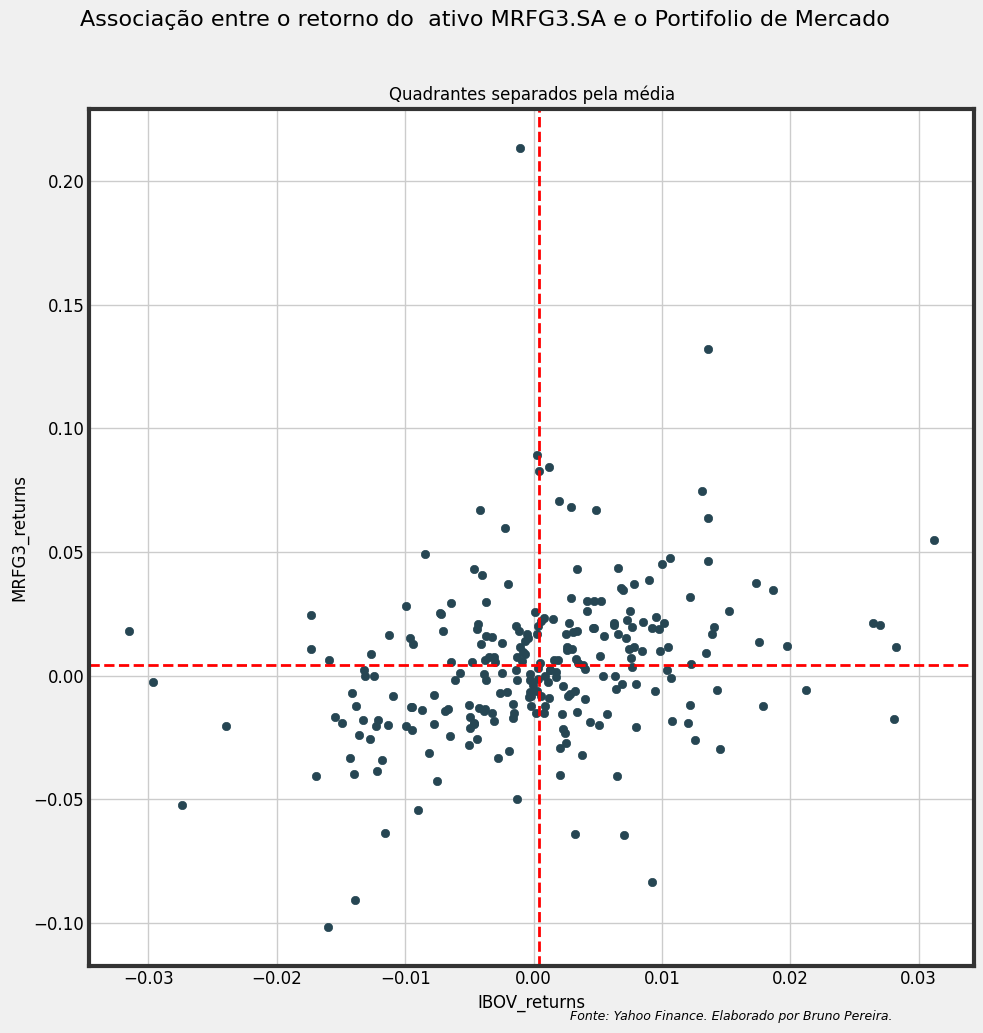

In [187]:
# Análisando o grau de associação do ativo em relação ao portifolio de mercado com quadrantes separados pela média 

lib.plot_scatter_with_reference_lines(
    data=stocks,
    x_col='IBOV_returns',
    y_col='MRFG3_returns',
    title='Associação entre o retorno do  ativo MRFG3.SA e o Portifolio de Mercado  ',
    subtitle='Quadrantes separados pela média',
    caption='Fonte: Yahoo Finance. Elaborado por Bruno Pereira.',
    stat='mean'
)


##  Retornos de ações podem ser decompostos em partes usando regressão linear

O modelo é dado por $r = \alpha + \beta \times m + \epsilon$.

Onde:

- $r$ é o **retorno da ação** (observado no mercado).
- $\alpha$ (alfa) é o **retorno esperado da ação quando o retorno do mercado é zero** — estimado pelo **investidor fundamentalista**.
- $\beta$ (beta) é a **sensibilidade da ação ao retorno do mercado** — mede o **retorno sistemático** e é estimado pelo **gestor de risco quantitativo**.
- $m$ é o **retorno do mercado** — sua expectativa é estimada pelo **investidor macroeconômico**.
- $\epsilon$ (épsilon) é o **ruído** ou **retorno idiossincrático** — parte específica da empresa, também analisado pelo **gestor de risco quantitativo**.

O modelo também é uma forma de decomposição do risco, que nada mais é do que a probabilidade de perdas suficientemente grandes para prejudicar a capacidade de continuar investindo.

A decomposição segue o seguinte modelo:


$$
\text{Retorno da ação} = \text{Retorno do mercado (fator sistemático)} + \text{Retorno idiossincrático (específico da empresa)}
$$

Ou seja:

$$
\text{Risco total} = \text{Risco sistemático} \; (\beta \times \text{volatilidade do mercado}) + \text{Risco idiossincrático} \; (\text{volatilidade específica da ação}).
$$

Como essas duas fontes de risco são consideradas independentes, a variância total é dada pela soma das variâncias:

$$
\sigma_{\text{total}}^2 = \sigma_{\text{mercado}}^2 + \sigma_{\text{idiossincrático}}^2
$$

onde $\sigma^2$ representa a volatilidade, que será definida e calculada a seguir.

​


In [188]:
# Definindo uma variável que representa o valor de Mercado ou Valor Investido em reais:
valor_mercado = 100000  # Cem mil 

# Definindo a volatilidade de mercado como o desvio - padrão do índice 
std_market = stocks['IBOV_returns'].std()

# Calculando o beta 

model = smf.ols("MRFG3_returns ~ IBOV_returns", data=stocks ) 
model_fit = model.fit() 

print(model_fit.summary()) # Séries temporais costuam ter R-squared , isso não significa que o modelo é ruim. Não estamos criando um modelo de inferencia de forma estrita. 
# então, ignore os resultados desse modelo, para a explicação. 

beta = model_fit.params.IBOV_returns 

# Agora vamos definir a volatilidade idiossincratica definida anteriomente como a variância dos residuos 
# Obter os resíduos
residuos = model_fit.resid

# Calcular a volatilidade idiossincrática diária (desvio padrão dos resíduos)
vol_idiossincratica = np.std(residuos)


# print(f"Volatilidade idiossincrática diária: {vol_idiossincratica:.4%}")

                            OLS Regression Results                            
Dep. Variable:          MRFG3_returns   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     21.92
Date:                Tue, 27 May 2025   Prob (F-statistic):           4.71e-06
Time:                        12:54:54   Log-Likelihood:                 510.13
No. Observations:                 247   AIC:                            -1016.
Df Residuals:                     245   BIC:                            -1009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0038      0.002      1.920   

In [189]:
# Decompondo o risco 
vol_mercado, vol_idios, vol_total = lib.calcular_volatilidades(valor_mercado, beta, std_market, vol_idiossincratica)

In [190]:
print(f"Volatilidade de Mercado : R${vol_mercado} \n")
print(f"Volatilidade idiossincrática : R${vol_idios} \n")
print(f"Volatilidade Total : R${vol_total} ")


Volatilidade de Mercado : R$919.455806520092 

Volatilidade idiossincrática : R$3067.7086441366046 

Volatilidade Total : R$3202.5357617759646 


Agora que temos a  volatilidade total, podemos usá-la para estimar a possível perda em valor de mercado do ativo em reais, com base no valor atual do ativo e num nível de confiança (por exemplo, 1 desvio padrão ≈ 68% de confiança, 2 desvios ≈ 95%).

In [191]:
# Estimativa de perda em R$ (1 desvio padrão)
perda_1dp = vol_total
      

# Se quiser ver para 2 desvios padrão (~95% de confiança)
perda_2dp = vol_total * 2

print(f"Volatilidade Total: R$ {vol_total:,.2f}")
print(f"Perda esperada (1σ): R$ {perda_1dp:,.2f}")
print(f"Perda esperada (2σ): R$ {perda_2dp:,.2f}")

Volatilidade Total: R$ 3,202.54
Perda esperada (1σ): R$ 3,202.54
Perda esperada (2σ): R$ 6,405.07


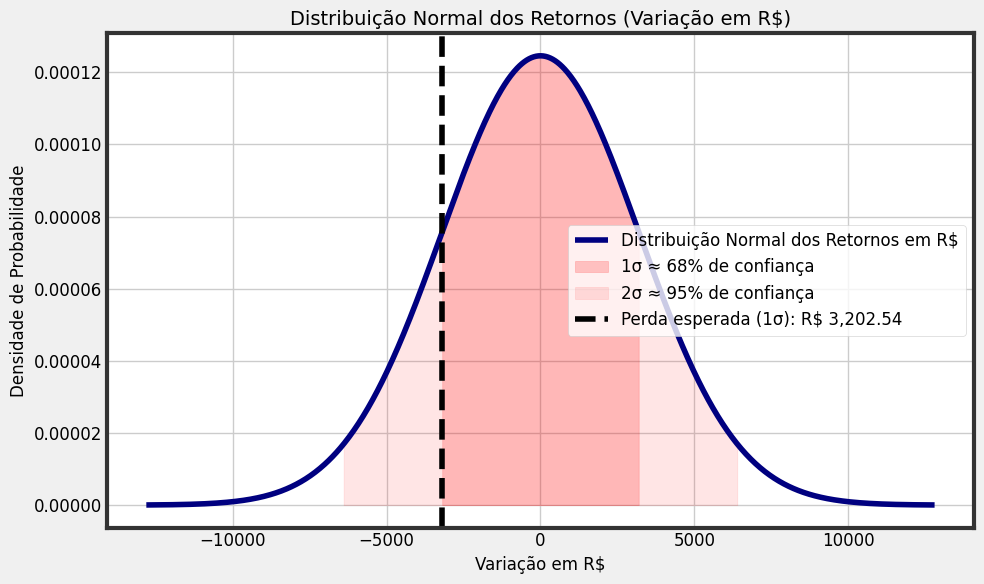

In [192]:
lib.plot_risco_normal(vol_mercado, vol_idios, vol_total )

O modelo pode ser estendido para um portfólio. O desempenho do portfólio pode ser dividido na contribuição de dois termos: um termo de mercado e um termo idiossincrático. Este é um exemplo simples de atribuição de performance, vamos escolher a ação de maior retorno acumulado e a ação de maior queda acumulada do periodo 

In [193]:
print(top_returns)

       Ações  Retornos
8   MRFG3.SA  1.494524
1   EMBR3.SA  0.766499
7   JBSS3.SA  0.636207
70  SBSP3.SA  0.611661
27  COGN3.SA  0.535335
54  CSAN3.SA -0.409932
49  BRKM5.SA -0.420888
62  RADL3.SA -0.424767
29  VAMO3.SA -0.470568
2   AZUL4.SA -0.897233


In [194]:
azul =  yf.download(ticker2,start, end)['Close']
azul.head(4)

[*********************100%***********************]  1 of 1 completed


Ticker,AZUL4.SA
Date,
2024-05-27,10.12
2024-05-28,9.63
2024-05-29,9.28
2024-05-31,9.47


In [195]:
azul['AZUL4_returns']= azul['AZUL4.SA'].pct_change()
azul.dropna(inplace= True)

In [196]:
stocks['AZUL4_returns'] = azul['AZUL4_returns']
stocks.head(3)

Ticker,MRFG3.SA,^BVSP,MRFG3_returns,IBOV_returns,AZUL4_returns
Date,,,,,
2024-05-28,9.966381,123780.0,0.000861,-0.005751,-0.048419
2024-05-29,9.829268,122707.0,-0.013758,-0.008669,-0.036345
2024-05-31,9.666447,122098.0,-0.016565,-0.004963,0.020474


In [197]:
# Obtendo Métricas 
tickers = ['MRFG3_returns', 'AZUL4_returns']
market = 'IBOV_returns'
caps = {'MRFG3_returns': 100000, 'WMT_returns': 50000, 'SPY_returns': 100000} # valor investido 

metricas = lib.obter_metricas_ativos(stocks, tickers, market, caps)

print(metricas)

{'MRFG3_returns': {'beta': np.float64(0.9632719883647552), 'idio_vol': np.float64(0.030677086441366044), 'market_value': 100000}, 'AZUL4_returns': {'beta': np.float64(1.8903767325307592), 'idio_vol': np.float64(0.05169286816976128), 'market_value': 100}}


In [198]:
# Decompondo volatilidade da carteira 
resultados = lib.calcular_volatilidade_carteira(metricas, std_market)

In [199]:
resultados

{'beta_dolar': np.float64(96516.2365097286),
 'vol_mercado': np.float64(9.212601960219466),
 'vol_idiossincratica': np.float64(3067.712999424268),
 'vol_total': np.float64(3067.726832505058)}

In [200]:
for i,j  in resultados.items():
    print(f"{i} : R$ {j:,.2f}")


beta_dolar : R$ 96,516.24
vol_mercado : R$ 9.21
vol_idiossincratica : R$ 3,067.71
vol_total : R$ 3,067.73



Mesmo que esse modelo de decomposição seja simples, ele traz implicações bastante poderosas: a volatilidade pode ter origem em uma fonte **sistemática**, relacionada ao mercado como um todo, ou em uma fonte **específica**, ligada a cada ação individualmente.

A partir dessa distinção, podemos refletir sobre onde realmente está nossa habilidade na gestão de portfólios:

- Se a sua habilidade está em **prever movimentos de mercado**, faz sentido operar com base em tendências amplas — comprando ou vendendo o mercado como um todo (por exemplo, o índice Ibovespa).
- Por outro lado, se a sua habilidade está em **identificar boas ou más empresas**, o foco deve estar nas **diferenças idiossincráticas** — comprando ações específicas e não apenas o índice.

Essa reflexão nos leva ao conceito de **Tracking Error**, que mede o  quanto o desempenho de um portfólio se desvia do desempenho de um índice de referência (benchmark) — como o Ibovespa.


# Tracking error 

**Definição de Tracking Error**

Tracking Error é, em geral, definido como:

$$
\text{Tracking Error (\%)} = \frac{\text{Volatilidade Idiossincrática do Portfólio}}{\text{Valor de Mercado da Carteira}} \times 100
$$

In [201]:
# i.e : 
# Valor de Mercado da Carteira
carteira = np.array(list(caps.values())) 
carteira = np.sum(carteira ) 
# Volatilidade Idiossincrática da Carteira
vol_idios_carteira = resultados['vol_idiossincratica']


# Tracking error 

carteira = np.sum(carteira ) 
tracking_error = (vol_idios_carteira / carteira ) * 100 

tracking_error


np.float64(1.2270851997697074)

O nosso portfólio apresenta um beta em reais de aproximadamente 96,5 mil, o que indica uma forte exposição sistemática ao mercado. Em outras palavras, a maior parte do risco da carteira é explicada pelos movimentos do mercado como um todo -- muito provavelmente devido à proporção dos valores investidos. Isso fica ainda mais evidente ao observar que a volatilidade associada ao mercado (volatilidade sistemática) é de cerca de 9.200 reais por dia, enquanto a volatilidade idiossincrática — ou seja, o risco que não pode ser explicado por fatores de mercado — é de aproximadamente 3.100 reais por dia.

Esse cenário reflete um portfólio que se comporta de maneira bastante semelhante ao mercado, mas ainda assim carrega um pequeno componente de risco específico de ativos. Esse componente não sistemático é justamente o que leva ao cálculo do tracking error: uma medida da volatilidade da performance do portfólio em relação a um benchmark, como o Ibovespa ou o S&P 500.

No nosso caso, o tracking error foi estimado em cerca de 1,23% ao dia. Isso significa que, mesmo que a carteira esteja fortemente correlacionada com o mercado -- que não é o caso -- , **ela ainda se desvia em média 1,23% por dia da performance do benchmark**. Esse desvio vem exclusivamente de decisões específicas — como escolher ações com características próprias, diferentes do índice.

Em termos práticos, esse número tem implicações importantes.  Um tracking error baixo  sugere que a estratégia está muito próxima do índice, ou seja, é pouco ativa. Isso é comum em fundos que desejam apenas replicar  o índice (como ETFs). Por outro lado, esse valor também indica que o gestor ou investidor está tomando pouco risco específico — ou seja, não está se afastando muito do que o mercado está fazendo. Assim, oportunidades de gerar alfa (retorno superior ao mercado) também tendem a ser mais limitadas, já que o portfólio se move quase como o índice. Portanto, ao olhar para esse tracking error de 1,23%, você pode concluir que a carteira está muito exposta ao mercado (alta beta), mas assume pouca exposição ativa fora do índice. **Isso é útil tanto para entender o perfil de risco do portfólio quanto para justificar sua performance diante de investidores**: se houver um desempenho muito diferente do benchmark, será improvável que venha de risco idiossincrático — e sim de uma má (ou excelente) alocação sistemática.